<a href="https://colab.research.google.com/github/jb2467/SMRG_Video/blob/main/SMRG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Hello
# Using first study as training, second as validation, could still be 60/20/20
# standarized AOI
# Rules:
##

# Label, WE, P with the parts.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from google.colab.patches import cv2_imshow
# Factor decsion what they scored the part, transcrpits for correct partipants and make best AOI for that
# Make areas of interest for all the part



In [2]:

path = '/content/drive/MyDrive/SMRG/Experiment #1/'

print(os.listdir(path))

subfolders = [f for f in os.listdir(path)]

videos = []

for subfolder in subfolders:
  files = os.listdir(path + '/' + subfolder)
  for file in files:
      videos.append(path + '/' + subfolder + '/' + file)
print(videos)

['5+ Years', 'Test 5+ ', 'Test 0-4', '0-2 Years', '3-4 Years']
['/content/drive/MyDrive/SMRG/Experiment #1//5+ Years/P15  .mp4', '/content/drive/MyDrive/SMRG/Experiment #1//5+ Years/P 5 .mp4', '/content/drive/MyDrive/SMRG/Experiment #1//5+ Years/P 2 .mp4', '/content/drive/MyDrive/SMRG/Experiment #1//5+ Years/P 18.mp4', '/content/drive/MyDrive/SMRG/Experiment #1//5+ Years/S 6 - p5_10_13_2023.mp4', '/content/drive/MyDrive/SMRG/Experiment #1//5+ Years/S 8 - p5_10_13_2023.mp4', '/content/drive/MyDrive/SMRG/Experiment #1//5+ Years/S 9 - p5_10_13_2023.mp4', '/content/drive/MyDrive/SMRG/Experiment #1//5+ Years/S 10 - p5_10_13_2023.mp4', '/content/drive/MyDrive/SMRG/Experiment #1//Test 5+ /P 14.mp4', '/content/drive/MyDrive/SMRG/Experiment #1//Test 5+ /P 6.mp4', '/content/drive/MyDrive/SMRG/Experiment #1//0-2 Years/P 12.mp4', '/content/drive/MyDrive/SMRG/Experiment #1//0-2 Years/Copy of P 10 S3 .mp4', '/content/drive/MyDrive/SMRG/Experiment #1//0-2 Years/Copy of P 3 S3 .mp4', '/content/drive/M

/content/drive/MyDrive/SMRG/Experiment #1/3-4 Years/Copy of P 3 - Resp p 16.mp4
    start_time  gaze_x  gaze_y  radius  duration  end_time
0     0.033333    1022     466      11  0.400000  0.433333
1     0.766667     998     552      13  0.466667  1.233333
2     1.266667    1052     554      13  0.366667  1.633333
3     1.666667    1108     528      13  0.733333  2.400000
4     2.500000    1018     482      14  0.500000  3.000000
5     3.133333     794     484      12  0.200000  3.333333
6     3.400000     836     528      13  0.233333  3.633333
7     3.633333     852     532      13  0.300000  3.933333
8     3.933333     776     472      11  0.966667  4.900000
9     5.266667     716     390      13  0.233333  5.500000
10    5.600000    1024     450      13  0.200000  5.800000
11    6.033333    1028     462      14  0.433333  6.466667
12    6.566667     778     474      13  0.400000  6.966667
13    7.066667    1024     466      12  0.233333  7.300000
14    7.333333    1028     500     

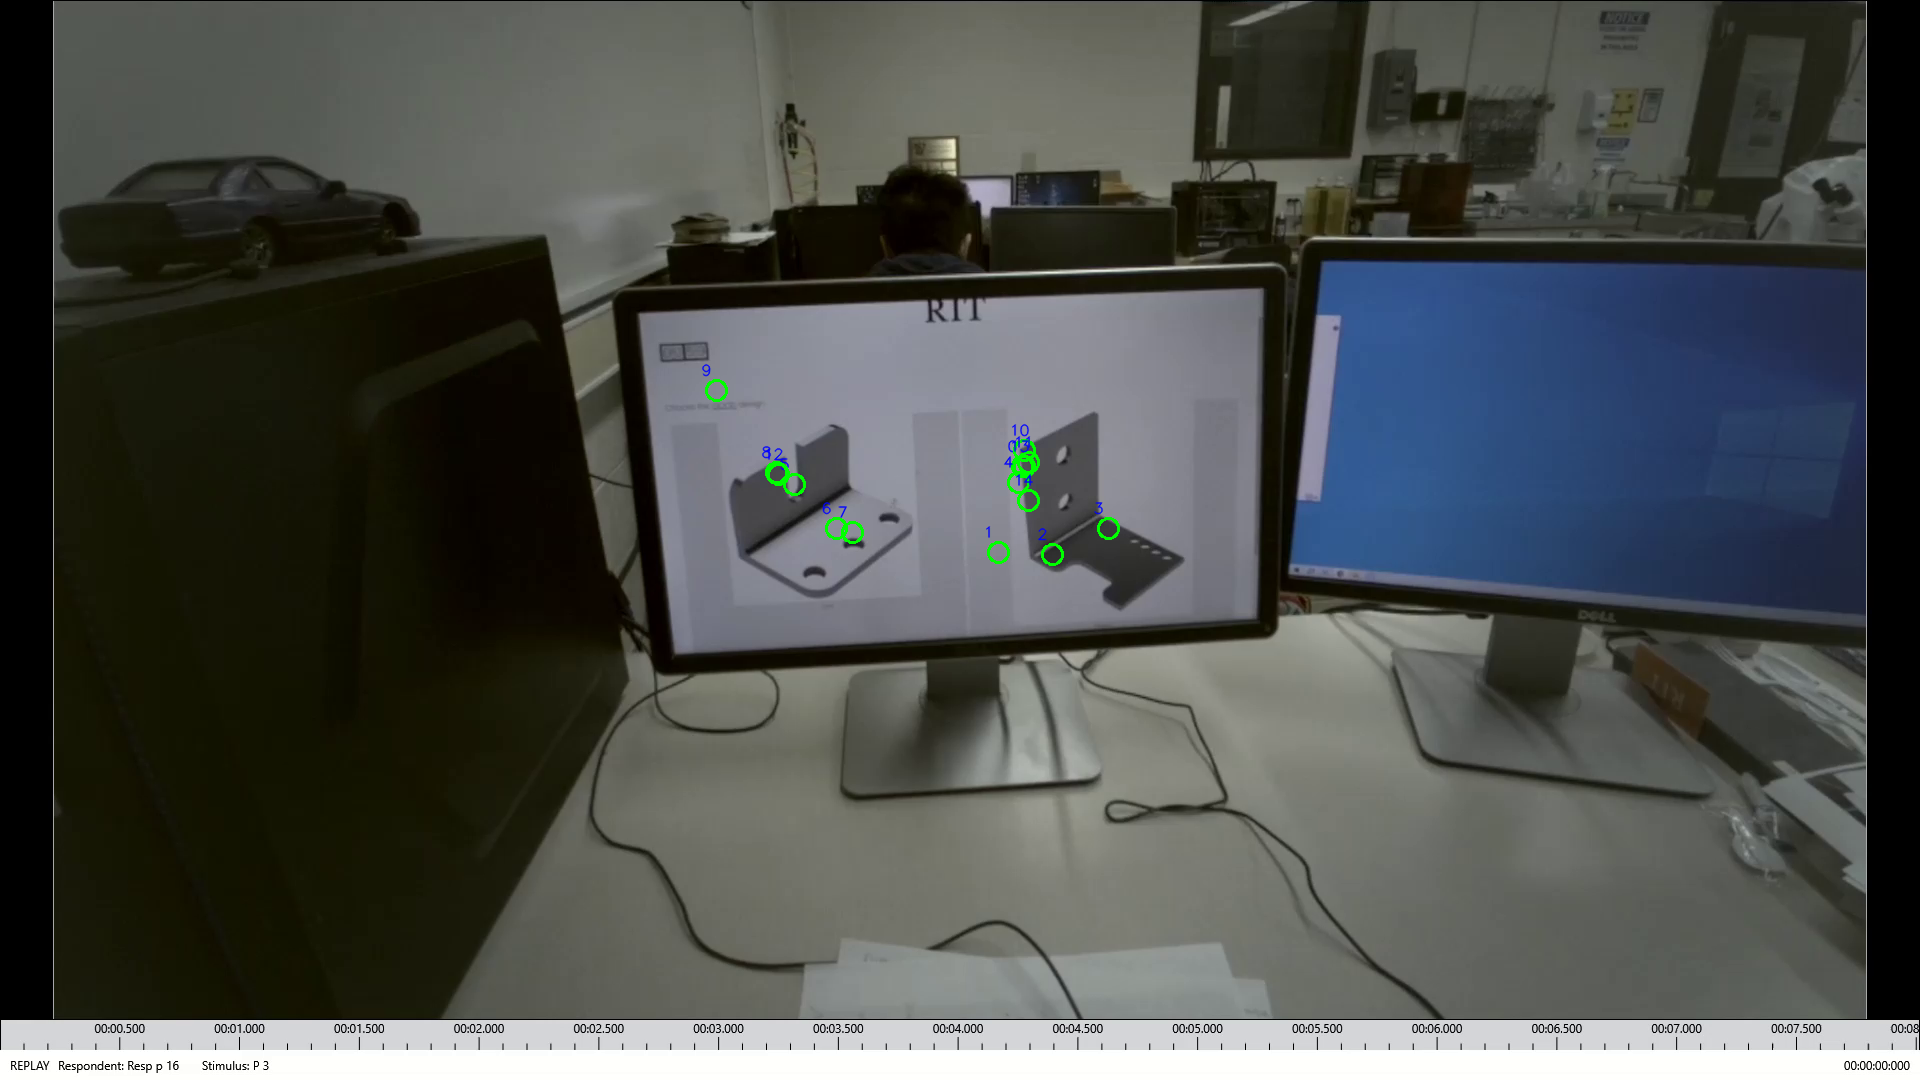

In [3]:
#20ms between fixations

def analyze_eye_tracking_video(video_file, movement_threshold=5, min_fixation_duration=0.20, grace_period_frames=10, same_gaze_df = None, same_raw_df = None ):
    cap = cv2.VideoCapture(video_file)
    gaze_data = [] if same_gaze_df is None else same_gaze_df.values.tolist()
    raw_gaze_data = [] if same_raw_df is None else same_raw_df.values.tolist()
    prev_x, prev_y = None, None  # Track previous gaze point
    start_time = None
    grace_period_counter = 0
    raw_gaze_data = []


    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_file}")
        return None
    # Use actual FPS from video file


    fps = cap.get(cv2.CAP_PROP_FPS)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Use actual time per frame for more accurate timestamps
        current_time_raw = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000  # Get timestamp in seconds

        gray = cv2.GaussianBlur(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), (5, 5), 0)
        circles = cv2.HoughCircles(
            gray, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=5, maxRadius=30
        )

        if circles is not None:
            circles = np.round(circles[0, :]).astype("int")
            for (x, y, r) in circles:
                grace_period_counter = 0  # Reset grace period
                raw_gaze_data.append([current_time_raw, x, y, r])
                if prev_x is not None and prev_y is not None:
                    distance_moved = np.sqrt((x - prev_x)**2 + (y - prev_y)**2)

                    if distance_moved > movement_threshold:
                        fixation_duration = current_time_raw - start_time
                        if fixation_duration >= min_fixation_duration - 1e-6:
                            end_time = start_time + fixation_duration
                            gaze_data.append([start_time, prev_x, prev_y, r, fixation_duration, end_time])

                        start_time = current_time_raw  # Reset start time for new fixation
                    prev_x, prev_y = x, y  # Update previous gaze point
                else:
                    start_time = current_time_raw  # Start new fixation
                    prev_x, prev_y = x, y

                break  # Use only the first circle detected
        else:
            grace_period_counter += 1
            if grace_period_counter > grace_period_frames and prev_x is not None:
                fixation_duration = current_time_raw - start_time
                if fixation_duration >= min_fixation_duration - 1e-6:
                    end_time = start_time + fixation_duration
                    gaze_data.append([start_time, prev_x, prev_y, 0, fixation_duration, end_time])

                prev_x, prev_y = None, None  # Reset when fixation ends

    if prev_x is not None:
        fixation_duration = current_time_raw - start_time
        if fixation_duration >= min_fixation_duration - 1e-6:
          end_time = start_time + fixation_duration
          gaze_data.append([start_time, prev_x, prev_y, 0, fixation_duration, end_time])

    cap.release()

    df = pd.DataFrame(gaze_data, columns=['start_time', 'gaze_x', 'gaze_y', 'radius', 'duration', 'end_time'])

    # Merge similar fixations if needed
    raw_df = pd.DataFrame(raw_gaze_data, columns=['timestamp', 'gaze_x', 'gaze_y', 'radius'])
    return df, raw_df


def display_fixations_on_video(video_file, gaze_df):
    cap = cv2.VideoCapture(video_file)

    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_file}")
        return

    ret, frame = cap.read()
    if not ret:
        print("Error: Unable to read the first frame")
        return

    real_frame = frame.copy()

    for index, row in gaze_df.iterrows():
        x, y, r = int(row['gaze_x']), int(row['gaze_y']), 10
        cv2.circle(real_frame, (x, y), r, (0, 255, 0), 2)
        cv2.putText(real_frame, str(index), (x - r - 5, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (255, 0, 0), 1, cv2.LINE_AA)
    cv2_imshow(real_frame)

    cap.release()
# Example usage
video_file = '/content/drive/MyDrive/SMRG/Experiment #1/3-4 Years/Copy of P 3 - Resp p 16.mp4'
print(video_file)
gaze_df, raw_df = analyze_eye_tracking_video(video_file)

if gaze_df is not None:
    print(gaze_df.tail(20))
    print(gaze_df.shape)
    print(f"Total gaze points detected: {raw_df.shape[0]}")
    print(raw_df.tail(20))
    display_fixations_on_video(video_file, gaze_df)
else:
    print("No valid gaze data to display.")


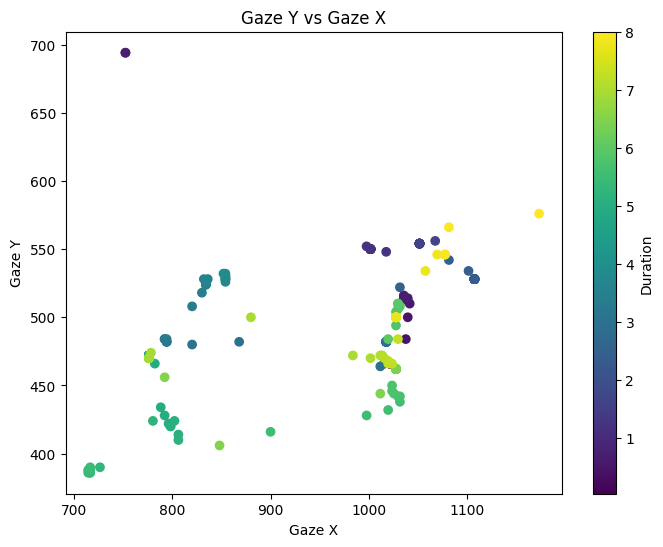

In [4]:

plt.figure(figsize=(8, 6))
plt.scatter(raw_df['gaze_x'], raw_df['gaze_y'], c=raw_df['timestamp'], cmap='viridis')
plt.xlabel('Gaze X')
plt.ylabel('Gaze Y')
plt.title('Gaze Y vs Gaze X')
_ = plt.colorbar(label='Duration')

In [5]:
gaze_df.shape

(15, 6)

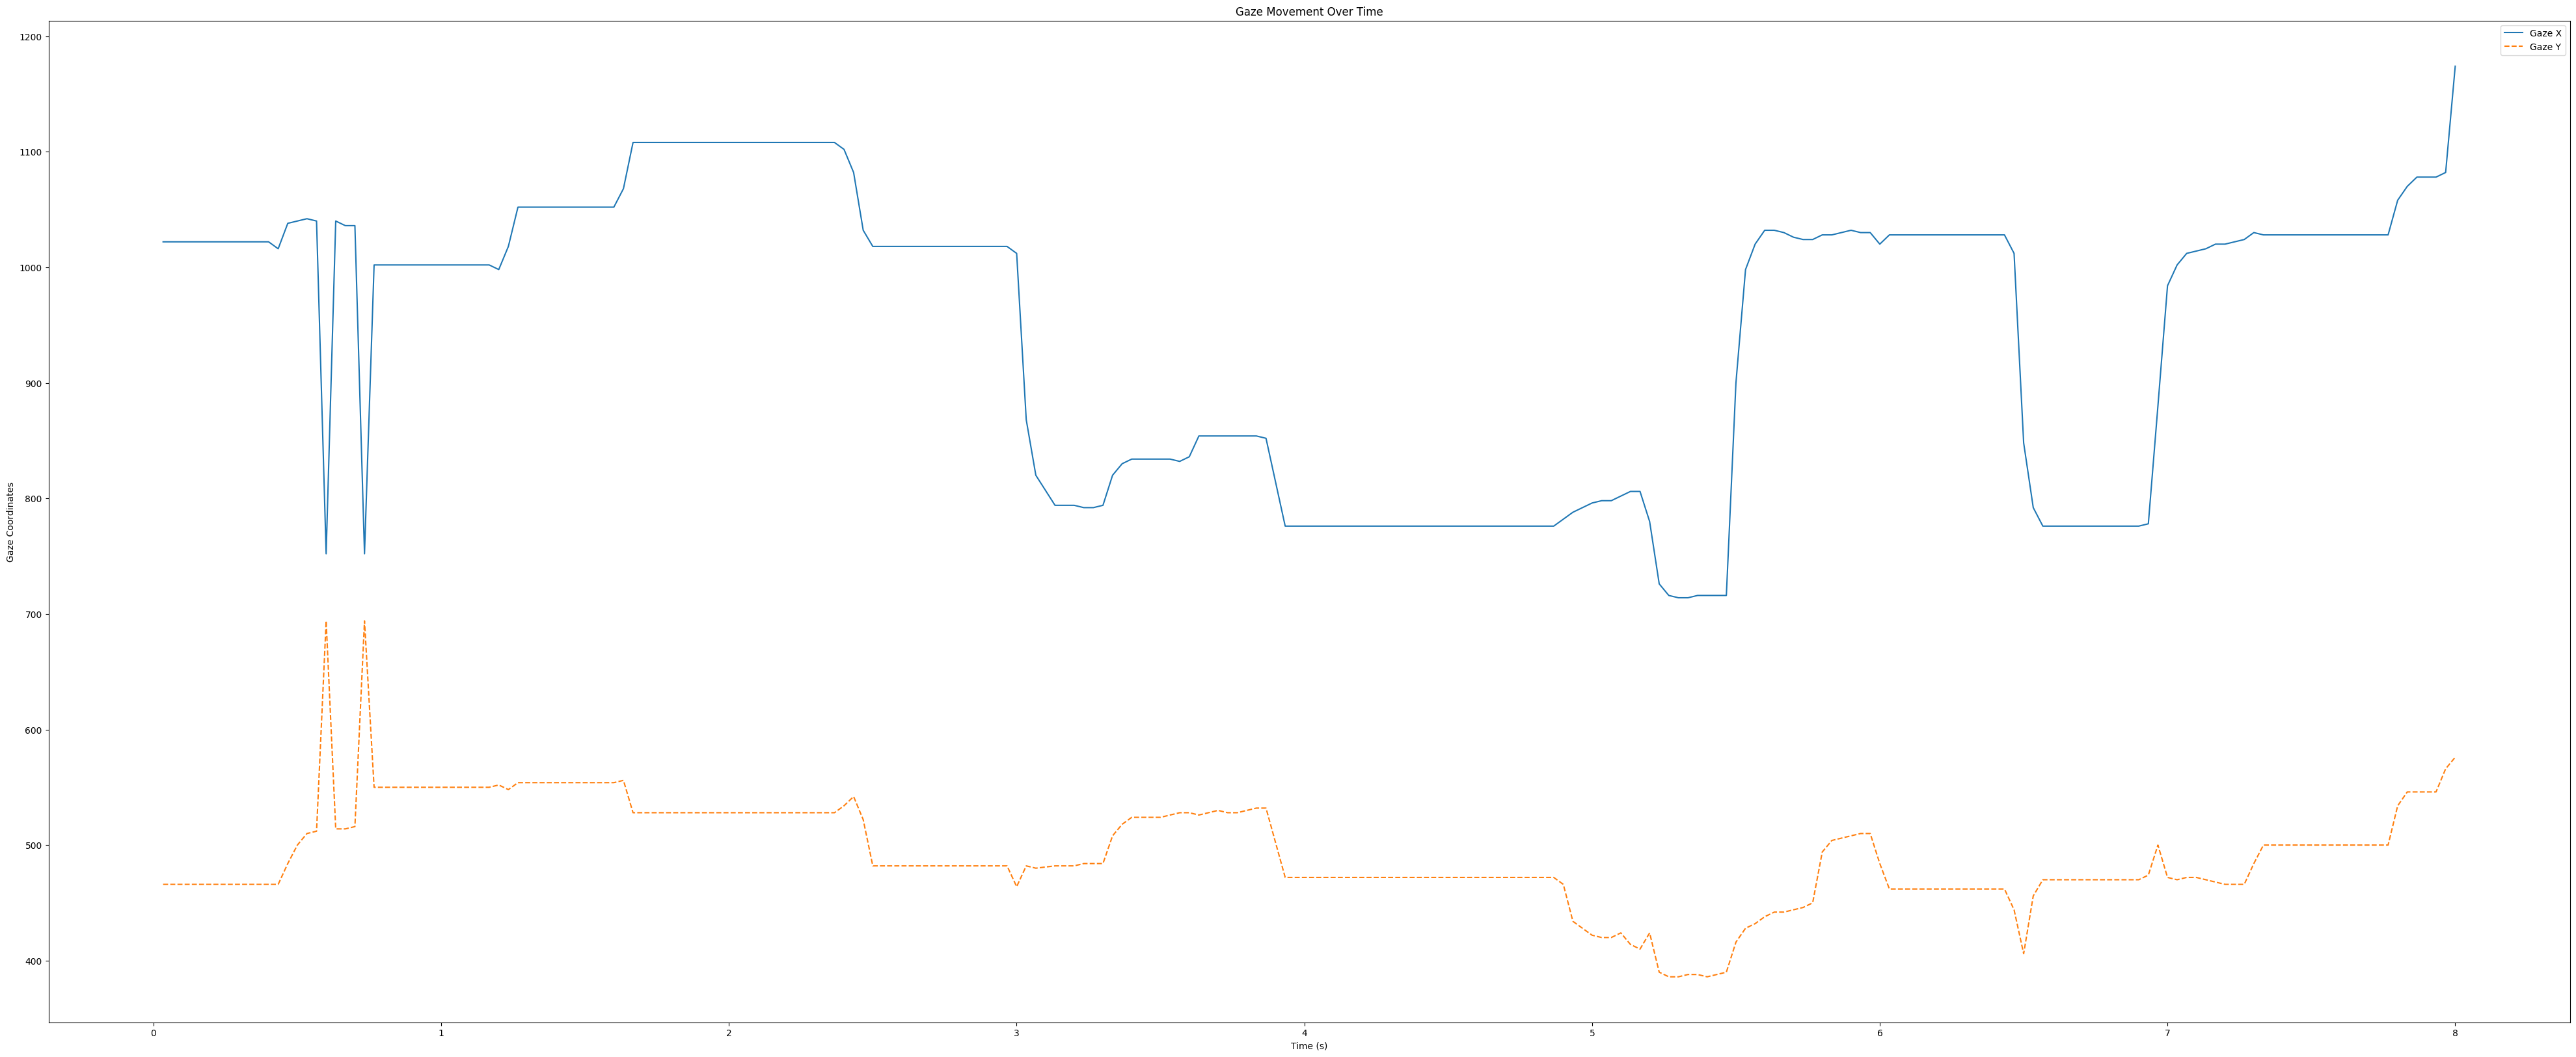

In [6]:
plt.figure(figsize=(50, 20))
plt.plot(raw_df['timestamp'], raw_df['gaze_x'], label='Gaze X')
plt.plot(raw_df['timestamp'], raw_df['gaze_y'], label='Gaze Y', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Gaze Coordinates')
plt.legend()
plt.title('Gaze Movement Over Time')

plt.show()


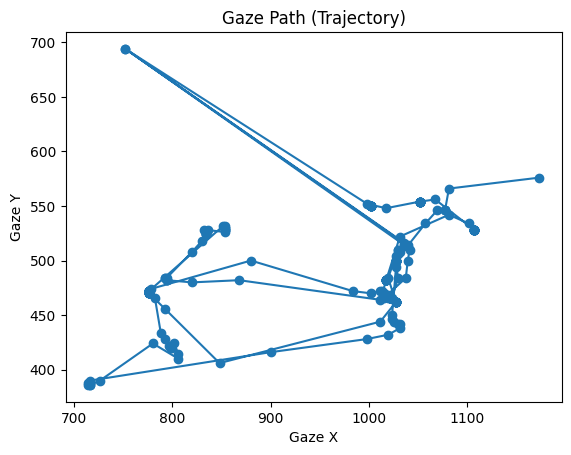

In [7]:
plt.plot(raw_df['gaze_x'], raw_df['gaze_y'], marker='o', linestyle='-')
plt.xlabel('Gaze X')
plt.ylabel('Gaze Y')
plt.title('Gaze Path (Trajectory)')
plt.show()


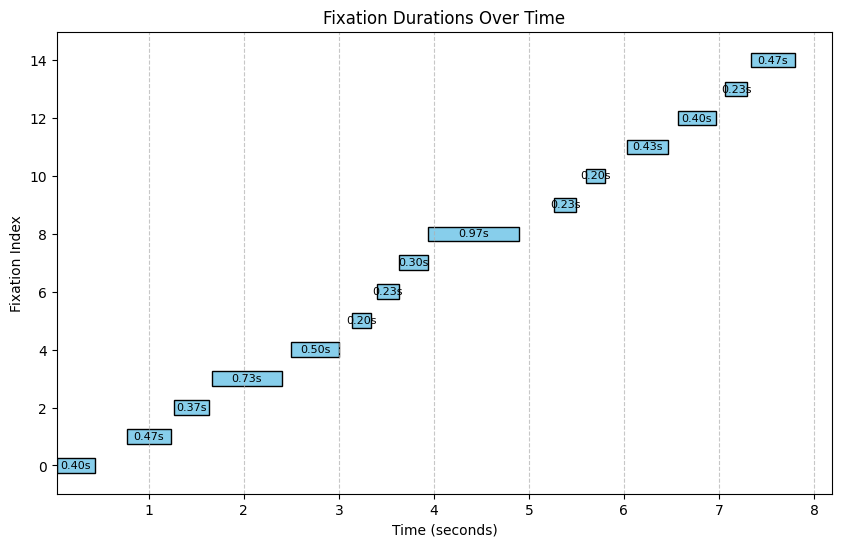

In [8]:

def plot_fixations(gaze_df):
    fig, ax = plt.subplots(figsize=(10, 6))

    for idx, row in gaze_df.iterrows():
        start = row['start_time']
        duration = row['duration']

        ax.barh(idx, duration, height=0.5, left=start, align='center', color='skyblue', edgecolor='black')
        ax.text(start + duration / 2, idx, f"{duration:.2f}s", ha='center', va='center', fontsize=8)

    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Fixation Index')
    ax.set_title('Fixation Durations Over Time')
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    plt.show()

if gaze_df is not None and not gaze_df.empty:
    plot_fixations(gaze_df)
else:
    print("No valid fixation data to plot.")


sns

78.0


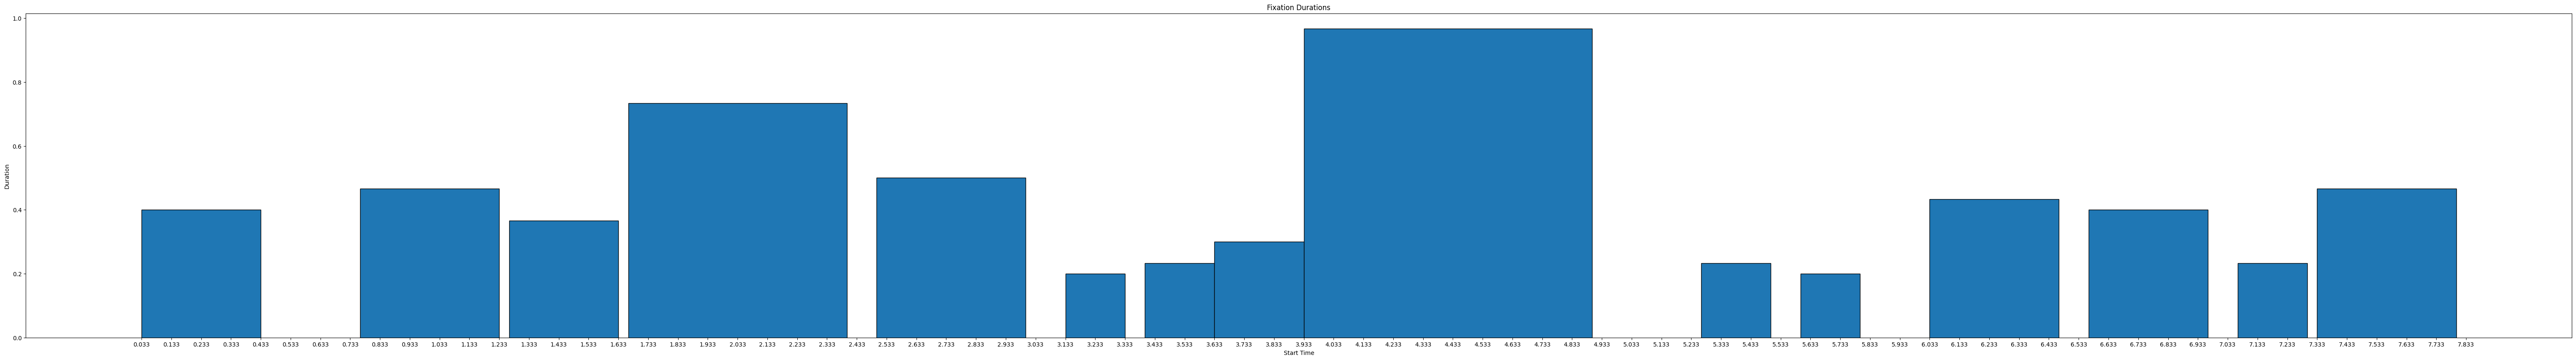

In [9]:
import matplotlib.pyplot as plt
import numpy as np

end_time = max(gaze_df['end_time'])
print(end_time/.1)
fig, ax = plt.subplots(figsize=(end_time/.1, 10))

start_times = gaze_df['start_time']
durations = gaze_df['duration']

ax.bar(start_times, durations, width=durations, align='edge', edgecolor='black')

ax.set_xlabel('Start Time')
ax.set_ylabel('Duration')
ax.set_title('Fixation Durations')

ax.set_xticks(np.arange(min(start_times), end_time +.1, 0.1))
plt.show()

<ipython-input-10-5fbe2f3d0f43>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(raw_df['radius'])


<Axes: xlabel='radius', ylabel='Density'>

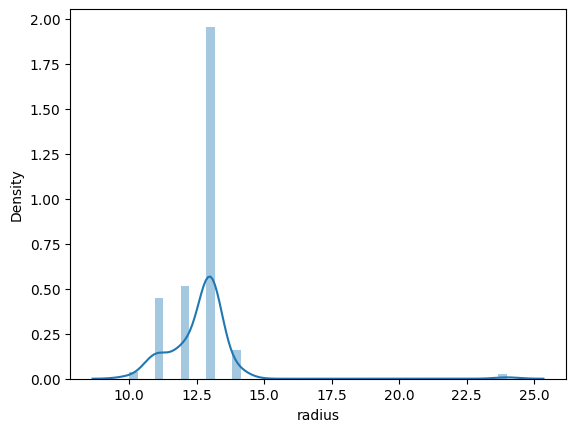

In [10]:
sns.distplot(raw_df['radius'])

<Axes: >

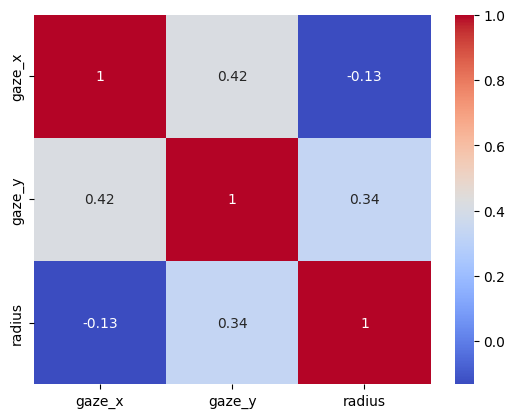

In [11]:
# prompt: make a correlation matrix with x, y

correlation_matrix = raw_df[['gaze_x', 'gaze_y', 'radius']].corr()
correlation_matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

<Axes: >

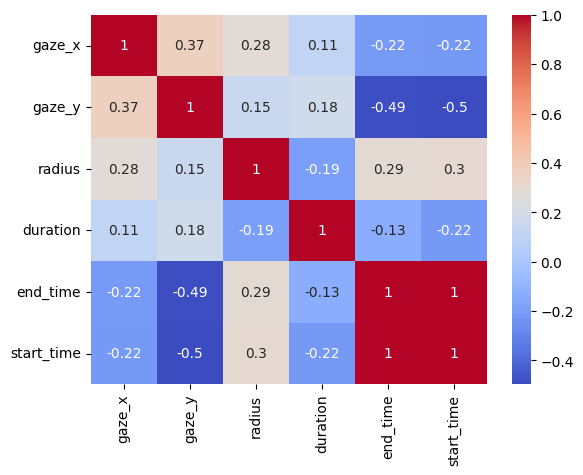

In [12]:
#generate a heatmap, to an image
matrix = gaze_df[['gaze_x', 'gaze_y', 'radius', 'duration', 'end_time', 'start_time']].corr()
matrix
sns.heatmap(matrix, annot=True, cmap='coolwarm')

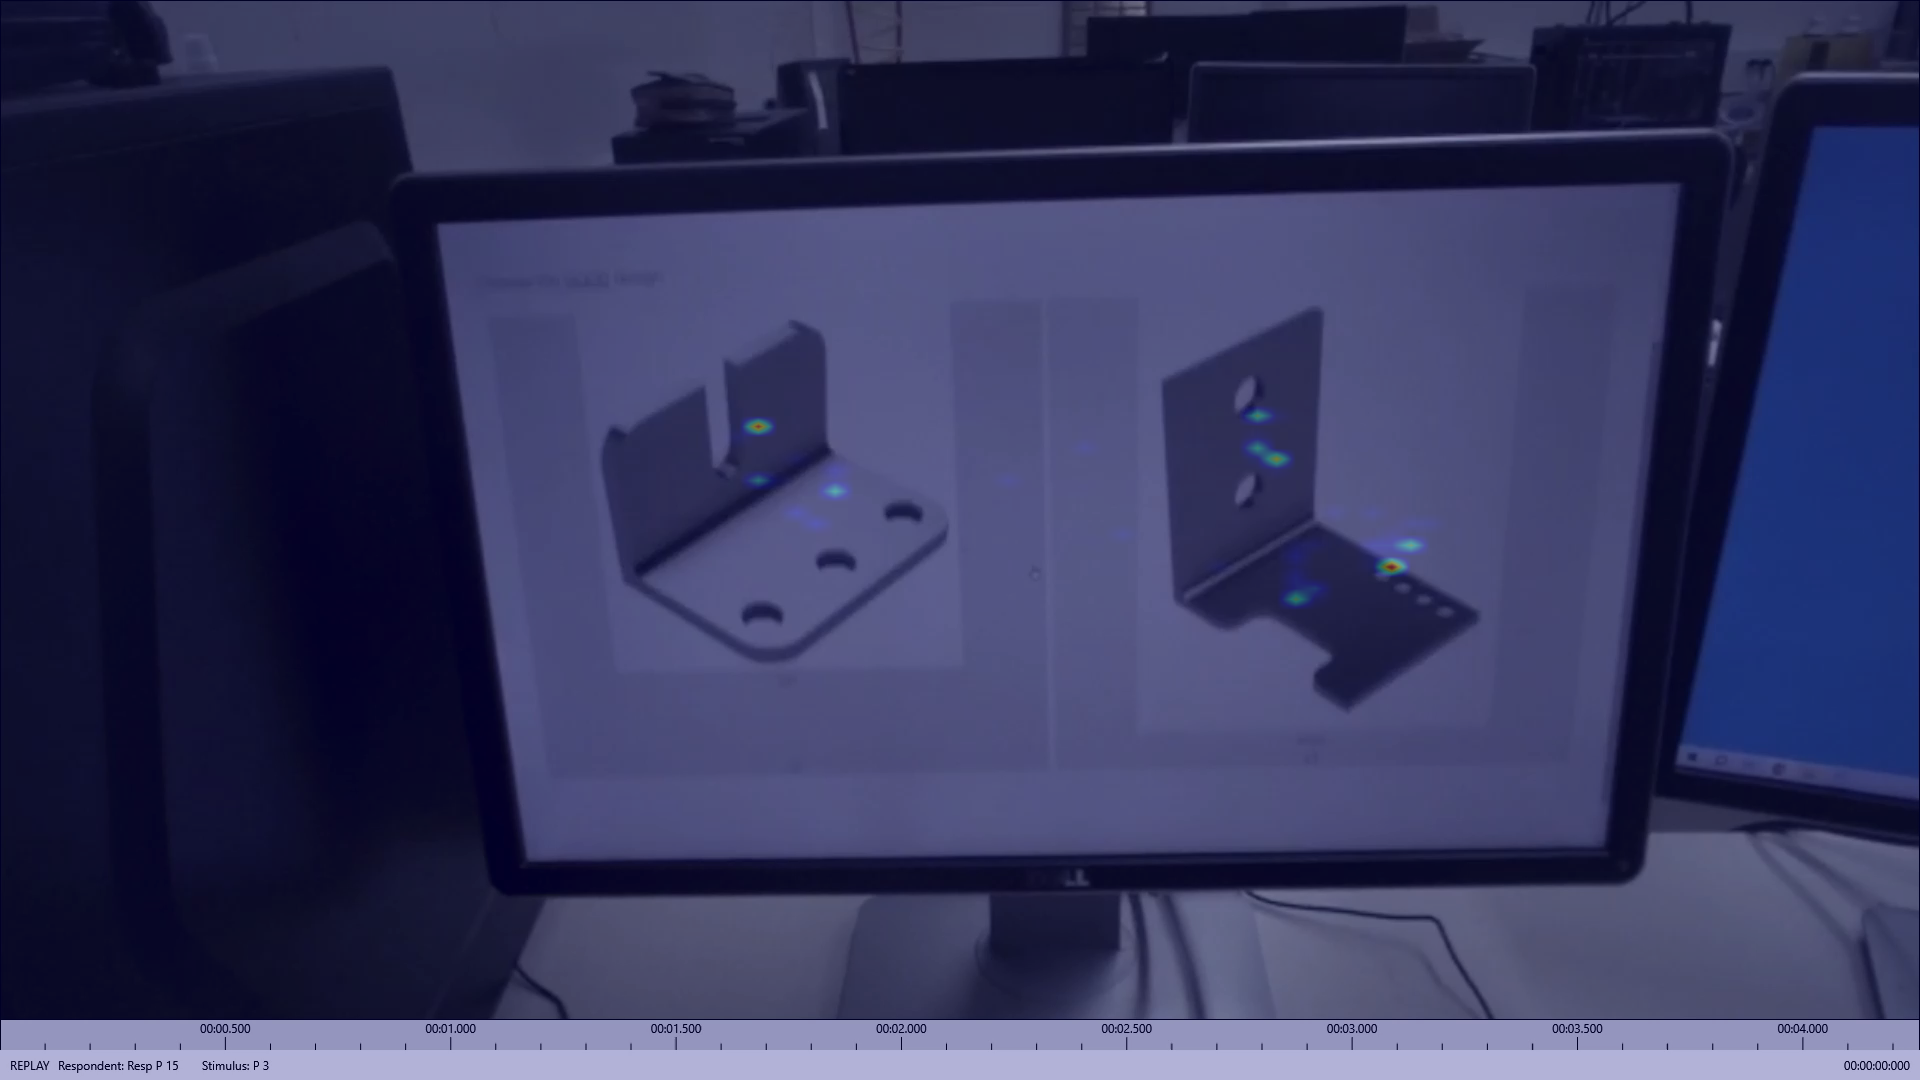

In [13]:
# prompt: With the raw data I want to make my own heat map and then plot it on the still frame

def create_heatmap_and_overlay(df, frame, heatmap_resolution=(100, 100)):
  heatmap_width, heatmap_height = heatmap_resolution

  heatmap = np.zeros((heatmap_height, heatmap_width), dtype=np.float32)
  for _, row in df.iterrows():
      x = int(row['gaze_x'] * heatmap_width / frame.shape[1])
      y = int(row['gaze_y'] * heatmap_height / frame.shape[0])
      if 0 <= x < heatmap_width and 0 <= y < heatmap_height:
          heatmap[y, x] += 1

  heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-8)

  heatmap = cv2.resize(heatmap, (frame.shape[1], frame.shape[0]))

  heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

  overlayed_frame = cv2.addWeighted(frame, 0.7, heatmap_color, 0.3, 0)

  return overlayed_frame


video_file = '/content/drive/MyDrive/SMRG/DFM 1/Participant15/P3/P 3 - Resp P 15 (1).mp4'
gaze_df, raw_df = analyze_eye_tracking_video(video_file)

cap = cv2.VideoCapture(video_file)

if not cap.isOpened():
    print(f"Error: Unable to open video file {video_file}")
else:
    ret, frame = cap.read()
    if ret:
        overlayed_frame = create_heatmap_and_overlay(raw_df, frame)
        cv2_imshow(overlayed_frame)
    else:
        print("Error: Unable to read a frame from the video.")

cap.release()

# I will give you 5 of the same stimuli with different participants. What we will do is tell it to generate statistics summarizing the fixations, proportion of faze/gaze, average time & number, etc. Once we get the statistics we identify the patterns and try to make connections.. 😃🔫

In [14]:
person_data = {
    'person_id': [1],
    'raw_data' : [raw_df],
    'gaze_data' : [gaze_df],
    'classifcation' : [1]
}

person_df = pd.DataFrame(person_data)
person_df.head()


,person_id,raw_data,gaze_data,classifcation
0,1,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,1


In [15]:
person_df['raw_data'][0].head()

,timestamp,gaze_x,gaze_y,radius
0,0.033333,1294,582,12
1,0.066667,1294,576,12
2,0.100000,1294,566,12
3,0.133333,1296,558,13
4,0.166667,1298,554,13


In [16]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Velcotiy
# time in between fixations
# time to first fixation
# firat fixation duration
# Dwell time()
# Fixations proportion with time
# Fixation and gaxe proportion
# last fixation duration
# peak velocity


In [44]:
#Velocity

def extract_features(gaze_df, raw_df):
  # Calculate velocity
  features = {}

  time_diff = np.diff(raw_df['timestamp'])
  distance = np.sqrt(np.diff(raw_df['gaze_x'])**2 + np.diff(raw_df['gaze_y'])**2)
  velocity = distance / time_diff
  features['avg_velocity'] = np.mean(velocity)
  features['peak_velocity'] = np.max(velocity)


  # Time to first fixation
  features['time_to_first_fixation'] = gaze_df['start_time'].iloc[0] - raw_df['timestamp'].iloc[0]

  # First fixation duration
  features['first_fixation_duration'] = gaze_df['duration'].iloc[0]

  # Last fixation duration
  features['last_fixation_duration'] = gaze_df['duration'].iloc[-1]

  # Dwell time (total time spent on fixations)
  features['total_dwell_time'] = gaze_df['duration'].sum()

  # Fixations proportion with time
  total_time = raw_df['timestamp'].iloc[-1] - raw_df['timestamp'].iloc[0]
  features['fixations_proportion_with_time'] = features['total_dwell_time'] / total_time

  # Fixation and gaze proportion
  features['fixation_gaze_proportion'] = len(gaze_df) / len(raw_df)

  return features


In [45]:
features = extract_features(gaze_df, raw_df)
features_df = pd.DataFrame([features])
print(features_df.head())

   avg_velocity  peak_velocity  time_to_first_fixation  \
0    342.009745    6726.693095                0.233333   

   first_fixation_duration  last_fixation_duration  total_dwell_time  \
0                      0.2                0.266667          4.366667   

   fixations_proportion_with_time  fixation_gaze_proportion  
0                        0.856209                  0.078431  


In [46]:
path = '/content/drive/MyDrive/SMRG/Experiment #1'

print(os.listdir(path))

subfolders = [f for f in os.listdir(path)]

videos = []

for subfolder in subfolders:
  files = os.listdir(path + '/' + subfolder)
  for file in files:
      videos.append(path + '/' + subfolder + '/' + file)
print(videos)


['5+ Years', 'Test 5+ ', 'Test 0-4', '0-2 Years', '3-4 Years']
['/content/drive/MyDrive/SMRG/Experiment #1/5+ Years/P15  .mp4', '/content/drive/MyDrive/SMRG/Experiment #1/5+ Years/P 5 .mp4', '/content/drive/MyDrive/SMRG/Experiment #1/5+ Years/P 2 .mp4', '/content/drive/MyDrive/SMRG/Experiment #1/5+ Years/P 18.mp4', '/content/drive/MyDrive/SMRG/Experiment #1/5+ Years/S 6 - p5_10_13_2023.mp4', '/content/drive/MyDrive/SMRG/Experiment #1/5+ Years/S 8 - p5_10_13_2023.mp4', '/content/drive/MyDrive/SMRG/Experiment #1/5+ Years/S 9 - p5_10_13_2023.mp4', '/content/drive/MyDrive/SMRG/Experiment #1/5+ Years/S 10 - p5_10_13_2023.mp4', '/content/drive/MyDrive/SMRG/Experiment #1/Test 5+ /P 14.mp4', '/content/drive/MyDrive/SMRG/Experiment #1/Test 5+ /P 6.mp4', '/content/drive/MyDrive/SMRG/Experiment #1/0-2 Years/P 12.mp4', '/content/drive/MyDrive/SMRG/Experiment #1/0-2 Years/Copy of P 10 S3 .mp4', '/content/drive/MyDrive/SMRG/Experiment #1/0-2 Years/Copy of P 3 S3 .mp4', '/content/drive/MyDrive/SMRG/E

In [47]:
import re
import pandas as pd

all_data = []
index = 0
for video in videos:
  gaze_df, raw_df = analyze_eye_tracking_video(video)
  num = 3
  if '0-2' in video:
      num = 1
  elif '3-4' in video:
      num = 2

    # Extract features
  features_df = pd.DataFrame([extract_features(gaze_df, raw_df)])



        # Add new entry if not found
  person_data = {
    'raw_data': [raw_df],
    'gaze_data': [gaze_df],
    'features': [features_df],
    'classification': [num]
  }
    all_data.append(pd.DataFrame(person_data))

all_data = pd.concat(all_data, ignore_index=True)
all_data.head()



,raw_data,gaze_data,features,classification
0,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_velocity peak_velocity time_to_first_...,3
1,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_velocity peak_velocity time_to_first_...,3
2,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius durati...,avg_velocity peak_velocity time_to_first_...,3
3,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius durati...,avg_velocity peak_velocity time_to_first_...,3
4,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_velocity peak_velocity time_to_first_...,3


In [48]:
all_data['features'][0].head(50)

,avg_velocity,peak_velocity,time_to_first_fixation,first_fixation_duration,last_fixation_duration,total_dwell_time,fixations_proportion_with_time,fixation_gaze_proportion
0,437.202613,6840.263153,0.433333,0.2,0.366667,3.433333,0.668831,0.070423


In [49]:
all_data.head(20)

,raw_data,gaze_data,features,classification
0,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_velocity peak_velocity time_to_first_...,3
1,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_velocity peak_velocity time_to_first_...,3
2,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius durati...,avg_velocity peak_velocity time_to_first_...,3
3,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius durati...,avg_velocity peak_velocity time_to_first_...,3
4,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_velocity peak_velocity time_to_first_...,3
5,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_velocity peak_velocity time_to_first_...,3
6,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_velocity peak_velocity time_to_first_...,3
7,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_velocity peak_velocity time_to_first_...,3
8,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius durati...,avg_velocity peak_velocity time_to_first_...,3
9,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius durati...,avg_velocity peak_velocity time_to_first_...,3


In [50]:
all_data.head(50)

,raw_data,gaze_data,features,classification
0,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_velocity peak_velocity time_to_first_...,3
1,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_velocity peak_velocity time_to_first_...,3
2,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius durati...,avg_velocity peak_velocity time_to_first_...,3
3,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius durati...,avg_velocity peak_velocity time_to_first_...,3
4,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_velocity peak_velocity time_to_first_...,3
5,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_velocity peak_velocity time_to_first_...,3
6,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_velocity peak_velocity time_to_first_...,3
7,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_velocity peak_velocity time_to_first_...,3
8,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius durati...,avg_velocity peak_velocity time_to_first_...,3
9,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius durati...,avg_velocity peak_velocity time_to_first_...,3


In [95]:
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

# Assuming `all_data` is already loaded
features_expanded = pd.concat([f for f in all_data["features"]], axis=0).reset_index(drop=True)
all_data_reset = all_data.drop(columns=["features"]).reset_index(drop=True)
all_data_expanded = pd.concat([all_data_reset, features_expanded], axis=1)

# Preparing data
X = all_data_expanded.drop(columns=["raw_data", "gaze_data", "classification"])
y = all_data_expanded["classification"]

# Models and their respective hyperparameters for tuning
model_params = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [5, 10, None],
            "min_samples_split": [2, 5, 10],
        },
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7],
        },
    },
    "SVM": {
        "model": SVC(probability=True, random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale", "auto"],
        },
    },
    "Neural Network": {
        "model": MLPClassifier(random_state=42, max_iter=1000),
        "params": {
            "hidden_layer_sizes": [(50,), (100,), (100, 50)],
            "activation": ["relu", "tanh"],
            "alpha": [0.0001, 0.001],
        },
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "max_depth": [5, 10, None],
            "min_samples_split": [2, 5, 10],
        },
    },
    "Naive Bayes": {"model": GaussianNB(), "params": {}},
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            "C": [0.01, 0.1, 1, 10, 100],
            "penalty": ["l2"],
        },
    },
    "K-Nearest Neighbors": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [1, 3, 5, 7, 9],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"],
        },
    },
}

# Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Evaluating each model
best_scores = {}
best_models = {}

for model_name, mp in model_params.items():
    print(f"\nEvaluating {model_name}...")

    pipe = Pipeline([("scaler", StandardScaler()), ("model", mp["model"])])

    grid_search = GridSearchCV(pipe, {"model__" + k: v for k, v in mp["params"].items()}, cv=3)
    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

    scores = []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit and predict
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        scores.append((y_test.values[0], y_pred[0]))

    # Evaluate results
    y_true, y_pred = zip(*scores)
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy for {model_name}: {accuracy:.4f}")
    print(classification_report(y_true, y_pred))
    best_scores[model_name] = accuracy

# Displaying the best model
best_model_name = max(best_scores, key=best_scores.get)
print(f"\nBest model: {best_model_name} with accuracy {best_scores[best_model_name]:.4f}")
best_model = best_models[best_model_name]




Evaluating Random Forest...
Best parameters for Random Forest: {'model__max_depth': 5, 'model__min_samples_split': 2, 'model__n_estimators': 50}
Accuracy for Random Forest: 0.5882
              precision    recall  f1-score   support

           1       0.67      0.50      0.57         8
           2       0.55      0.69      0.61        16
           3       0.62      0.50      0.56        10

    accuracy                           0.59        34
   macro avg       0.61      0.56      0.58        34
weighted avg       0.60      0.59      0.59        34


Evaluating Gradient Boosting...
Best parameters for Gradient Boosting: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
Accuracy for Gradient Boosting: 0.4706
              precision    recall  f1-score   support

           1       0.33      0.25      0.29         8
           2       0.47      0.56      0.51        16
           3       0.56      0.50      0.53        10

    accuracy                

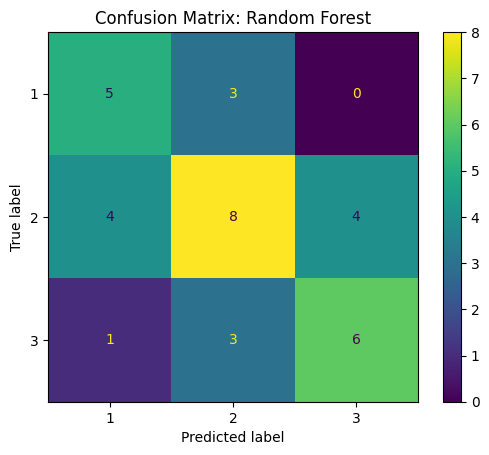

In [96]:
from sklearn.metrics import ConfusionMatrixDisplay
unique_labels = sorted(set(y_true))

ConfusionMatrixDisplay.from_predictions(
  y_true,
  y_pred,
  display_labels=unique_labels,
)
plt.title(f"Confusion Matrix: {best_model_name}")
plt.show()

